# Feature selection

## Encontrar la mejor combinación de variables de entrada

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow import keras
import tensorflow as tf

Importar datos

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')
df = df.between_time('08:00:00','17:00:00')
df = df[['SRGLOAVG1H','TAMAX1H','TAMIN1H','RHMAX1H','RHMIN1H','PRSUM1H','PAAVG1H','PAMAX1H','PAMIN1H','WS1HA','WS1HX','WD1HA']]
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')
df_test = df_test.between_time('08:00:00','17:00:00')
df_test = df_test[['SRGLOAVG1H','TAMAX1H','TAMIN1H','RHMAX1H','RHMIN1H','PRSUM1H','PAAVG1H','PAMAX1H','PAMIN1H','WS1HA','WS1HX','WD1HA']]

In [ ]:
x_train = df.drop(columns=['SRGLOAVG1H'])

In [ ]:
x_train.head()

,TAMAX1H,TAMIN1H,RHMAX1H,RHMIN1H,PRSUM1H,PAAVG1H,PAMAX1H,PAMIN1H,WS1HA,WS1HX,WD1HA
Local_Time,,,,,,,,,,,
2015-01-01 08:00:00,12.2,9.5,96.0,89.0,0.0,743.5,743.7,743.1,2.5,4.6,42
2015-01-01 09:00:00,15.1,12.2,89.0,76.0,0.0,743.8,743.9,743.7,3.3,5.8,59
2015-01-01 10:00:00,18.1,15.1,79.0,57.0,0.0,743.7,743.9,743.4,4.4,8.4,40
2015-01-01 11:00:00,18.4,16.7,66.0,58.0,0.0,743.2,743.4,742.8,4.0,8.1,35
2015-01-01 12:00:00,18.5,17.2,65.0,55.0,0.0,742.6,742.9,742.3,3.5,7.6,34


In [ ]:
y_train = df['SRGLOAVG1H'].values

In [ ]:
y_train

array([107., 394., 728., ..., 331., 334., 132.])

Normalizar datos

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df)
scaled_train = scaler.transform(df)
scaled_test = scaler.transform(df_test)

## Random Forest

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rf = RandomForestRegressor()

In [ ]:
# Number of trees in random forest
n_estimators = [100,200,300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,50,70,100]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
random_grid

{'bootstrap': [True, False],
 'max_depth': [20, 50, 70, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300]}

Optimizando hiperparámetros para el random forest

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 50, 70, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
best_random = rf_random.best_estimator_

In [ ]:
rf.fit(x_train,y_train)

RandomForestRegressor()

In [ ]:
features = x_train.columns

criterion{“squared_error”, “absolute_error”, “poisson”}, default=”squared_error”

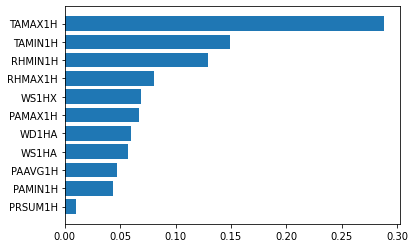

In [ ]:
f_i = list(zip(features,best_random.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [ ]:
importance = best_random.feature_importances_

In [ ]:
np.mean(importance)

0.09090909090909091

In [ ]:
thr = np.mean(importance)

In [ ]:
for i,num in enumerate(importance):
  if(num>thr):
    print(i)

0
1
3


SelectFromModel thr=mean

In [ ]:
selection = SelectFromModel(best_random)
selection.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(max_depth=70,
                                                max_features='sqrt',
                                                min_samples_leaf=2,
                                                min_samples_split=5,
                                                n_estimators=200))

In [ ]:
selection.get_support()

array([ True,  True, False,  True, False, False, False, False, False,
       False, False])

In [ ]:
features[selection.get_support()]

Index(['TAMAX1H', 'TAMIN1H', 'RHMIN1H'], dtype='object')

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
scaled_train_df = pd.DataFrame(scaled_train)


Las variables están en este orden: SRGLOAVG1H, TAMAX1H, WS1HA, RHMAX1H

In [ ]:
scaled_train_df.head()

,0,1,2,3
0,0.077307,0.408602,0.269663,0.942857
1,0.315877,0.564516,0.359551,0.842857
2,0.593516,0.725806,0.483146,0.700000
3,0.344140,0.741935,0.438202,0.514286
4,0.323358,0.747312,0.382022,0.500000


La variable de radiación solar siempre se va a usar como entrada, así que se busca realizar una prueba con las combinaciones de las demás variables.

In [ ]:
import itertools

In [ ]:
all_combinations = [list(itertools.combinations([1,2,3],n)) for n in range(3)]

In [ ]:
all_combinations

[[()], [(1,), (2,), (3,)], [(1, 2), (1, 3), (2, 3)]]

In [ ]:
options = []
for comb_set in all_combinations:
  for comb in comb_set:
    options.append(comb)

In [ ]:
options

[(), (1,), (2,), (3,), (1, 2), (1, 3), (2, 3)]

In [ ]:
options = options[1:]

In [ ]:
options

[(1,), (2,), (3,), (1, 2), (1, 3), (2, 3)]

In [ ]:
train_options = []
for option in options:
  variables = [0]
  for variable in option:
    variables.append(int(variable))
  train_options.append(variables)
train_options

[[0, 1], [0, 2], [0, 3], [0, 1, 2], [0, 1, 3], [0, 2, 3]]

In [ ]:
scaled_train_df.iloc[0]

0    0.077307
1    0.408602
2    0.269663
3    0.942857
Name: 0, dtype: float64

In [ ]:
for option in train_options:
  print(scaled_train_df.iloc[0][option])

0    0.077307
1    0.408602
Name: 0, dtype: float64
0    0.077307
2    0.269663
Name: 0, dtype: float64
0    0.077307
3    0.942857
Name: 0, dtype: float64
0    0.077307
1    0.408602
2    0.269663
Name: 0, dtype: float64
0    0.077307
1    0.408602
3    0.942857
Name: 0, dtype: float64
0    0.077307
2    0.269663
3    0.942857
Name: 0, dtype: float64


In [ ]:
def create_Model(n_input, LSTM_neurons = 100, n_features=0):
  # define model
  model = Sequential()
  model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1)))
  model.add(Dense(n_output))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
scaled_train_df.iloc[15:19]

,0,1,2,3
15,0.369909,0.704301,0.674157,0.442857
16,0.301746,0.661290,0.707865,0.471429
17,0.239401,0.655914,0.651685,0.485714
18,0.246052,0.677419,0.696629,0.485714


In [ ]:
for option in train_options:
  generator = TimeseriesGenerator(scaled_train_df[option], scaled_train_df[0], length=18, batch_size=1) 
  print(generator[0])

In [ ]:
column_name = list(df.columns)

In [ ]:
scaled_test_df = pd.DataFrame(scaled_train)

In [ ]:
model_input = np.array(scaled_test_df.iloc[0:18][[0,1]])

In [ ]:
model_input.reshape(1,18,2)

array([[[0.07730673, 0.40860215],
        [0.31587697, 0.56451613],
        [0.59351621, 0.72580645],
        [0.34413965, 0.74193548],
        [0.32335827, 0.74731183],
        [0.57772236, 0.83333333],
        [0.31837074, 0.81182796],
        [0.48212801, 0.8655914 ],
        [0.24438903, 0.86021505],
        [0.10141313, 0.58602151],
        [0.06899418, 0.45698925],
        [0.08645054, 0.49462366],
        [0.17705736, 0.56989247],
        [0.32751455, 0.64516129],
        [0.54862843, 0.72580645],
        [0.36990856, 0.70430108],
        [0.30174564, 0.66129032],
        [0.2394015 , 0.65591398]]])

In [ ]:
scaled_test_df.shape

(2920, 4)

In [ ]:
best_model = None
lowest_error = 58000

In [ ]:
n_input = 18 # horas hacia atrás
n_output = 1 # horas predichas

In [ ]:
for option in train_options:
  n_features = len(option)-1 # variables exógenas
  generator = TimeseriesGenerator(scaled_train_df[option], scaled_train_df[0], length=n_input, batch_size=n_output)  
  model = create_Model(n_input,LSTM_neurons=90,n_features=n_features)
  names = []
  for num in option:
    names.append(column_name[num])
  print('Combinacion',names)
  model.fit(generator,epochs=5,verbose=False)
  predictions = []
  for j in range(n_input,len(df_test)):
    model_input = np.array(scaled_test_df.iloc[j-n_input:j][option])
    model_input = model_input.reshape((1, n_input, n_features+1))
    predictions.append(model.predict(model_input)[0])
  predictions = np.ndarray.flatten(np.array(predictions))  
  # reshape for inverse transform
  test_predictions =  np.zeros(shape=(len(predictions), 4))
  # first column is Global radiation
  test_predictions[:,0] = predictions
  true_predictions = scaler.inverse_transform(test_predictions)
  true_predictions = np.ndarray.flatten(true_predictions[:,0])
  true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)
  error = mean_squared_error(true_values,true_predictions)
  print('Error:',error)
  if(error < lowest_error):
    best_model = model
    lowest_error = error
    print('Best:',names)

Combinacion ['SRGLOAVG1H', 'TAMAX1H']
Error: 55365.54702481891
Best: ['SRGLOAVG1H', 'TAMAX1H']
Combinacion ['SRGLOAVG1H', 'WS1HA']
Error: 52783.484815315795
Best: ['SRGLOAVG1H', 'WS1HA']
Combinacion ['SRGLOAVG1H', 'RHMAX1H']
Error: 54177.98460268963
Combinacion ['SRGLOAVG1H', 'TAMAX1H', 'WS1HA']
Error: 58312.244445536264
Combinacion ['SRGLOAVG1H', 'TAMAX1H', 'RHMAX1H']
Error: 58093.561227210696
Combinacion ['SRGLOAVG1H', 'WS1HA', 'RHMAX1H']
Error: 54590.14598753208


random forest feature selection

In [ ]:
best_model.save('./drive/MyDrive/DatosInvestigacion/RSG_multi_model.h5')

In [ ]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90)                33480     
                                                                 
 dense_2 (Dense)             (None, 1)                 91        
                                                                 
Total params: 33,571
Trainable params: 33,571
Non-trainable params: 0
_________________________________________________________________
